# HMM Activity Recognition

This notebook implements a complete pipeline for human activity recognition using Hidden Markov Models:
1. Data loading and preprocessing
2. Feature extraction (time and frequency domain)
3. HMM training with Baum-Welch algorithm
4. Activity decoding with Viterbi algorithm
5. Evaluation on unseen data
6. Performance metrics (sensitivity, specificity, accuracy)


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)


In [8]:
def load_and_clean_data(data_dir='dataset'):
    """
    Load sensor data from CSV files and perform basic cleaning.
    """
    sensor_data = defaultdict(list)
    
    # Get all activity folders
    activity_folders = glob.glob(os.path.join(data_dir, '*'))
    activity_folders = [f for f in activity_folders if os.path.isdir(f)]
    
    for folder in sorted(activity_folders):
        folder_name = os.path.basename(folder)
        
        # Extract activity name
        activity_name = ''.join([i for i in folder_name if not i.isdigit()]).split('-')[0]
        
        # Load accelerometer data
        accel_file = os.path.join(folder, 'Accelerometer.csv')
        gyro_file = os.path.join(folder, 'Gyroscope.csv')
        
        if os.path.exists(accel_file) and os.path.exists(gyro_file):
            try:
                # Load sensors
                accel_df = pd.read_csv(accel_file)
                gyro_df = pd.read_csv(gyro_file)
                
                # Remove time column, keep seconds_elapsed
                accel_df = accel_df.drop('time', axis=1) if 'time' in accel_df.columns else accel_df
                gyro_df = gyro_df.drop('time', axis=1) if 'time' in gyro_df.columns else gyro_df
                
                # Merge accelerometer and gyroscope data
                merged_df = accel_df.merge(gyro_df, on=['seconds_elapsed'], suffixes=('_accel', '_gyro'))
                
                # Rename columns for clarity
                merged_df = merged_df.rename(columns={
                    'x_accel': 'accel_x', 'y_accel': 'accel_y', 'z_accel': 'accel_z',
                    'x_gyro': 'gyro_x', 'y_gyro': 'gyro_y', 'z_gyro': 'gyro_z'
                })
                
                # Add metadata
                merged_df['activity'] = activity_name
                merged_df['trial'] = folder_name
                merged_df['sequence_id'] = f"{activity_name}_{len(sensor_data[activity_name])}"
                merged_df['sample_index'] = np.arange(len(merged_df))
                
                # Remove missing values
                merged_df = merged_df.dropna()
                
                sensor_data[activity_name].append(merged_df)
                print(f"Loaded and cleaned: {folder_name}")
                
            except Exception as e:
                print(f"Error loading {folder_name}: {e}")
    
    # Combine all data
    all_data = []
    for activity, dataframes in sensor_data.items():
        all_data.extend(dataframes)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df, sensor_data


In [9]:
# Load and clean the data
print("Loading and cleaning data...")
cleaned_df, sensor_dict = load_and_clean_data('dataset')

print(f"\nTotal samples: {len(cleaned_df)}")
print(f"\nActivities found: {sorted(cleaned_df['activity'].unique())}")
print(f"\nColumns: {cleaned_df.columns.tolist()}")


Loading and cleaning data...
Loaded and cleaned: holding1-2025-10-23_15-10-03
Loaded and cleaned: holding2-2025-10-25_09-36-20
Loaded and cleaned: holding3-2025-10-25_09-36-31
Loaded and cleaned: holding4-2025-10-25_09-36-43
Loaded and cleaned: holding5-2025-10-25_09-37-01
Loaded and cleaned: jumping1-2025-10-23_15-07-37
Loaded and cleaned: jumping2-2025-10-23_15-07-59
Loaded and cleaned: jumping3-2025-10-25_09-08-09
Loaded and cleaned: jumping4-2025-10-25_09-08-28
Loaded and cleaned: jumping5-2025-10-25_09-08-40
Loaded and cleaned: running1-2025-10-23_15-06-27
Loaded and cleaned: running3-2025-10-25_09-09-30
Loaded and cleaned: running4-2025-10-25_09-09-43
Loaded and cleaned: running5-2025-10-25_09-09-56
Loaded and cleaned: running_2-2025-10-23_15-07-13
Loaded and cleaned: shaking1-2025-10-23_15-06-51
Loaded and cleaned: shaking2-2025-10-23_15-09-34
Loaded and cleaned: shaking3-2025-10-25_09-10-55
Loaded and cleaned: shaking4-2025-10-25_09-11-07
Loaded and cleaned: shaking5-2025-10-25

In [10]:
# Organize data by activity
organized_data = {}
for activity in cleaned_df['activity'].unique():
    organized_data[activity] = cleaned_df[cleaned_df['activity'] == activity]
    print(f"{activity}: {len(organized_data[activity])} samples")

print(f"\nData is now organized by activity. Access using organized_data['activity_name']")


holding: 4947 samples
jumping: 4823 samples
running: 4107 samples
running_: 954 samples
shaking: 4455 samples
still: 4983 samples
walking: 4989 samples

Data is now organized by activity. Access using organized_data['activity_name']


## 5. Visualize Cleaned Data


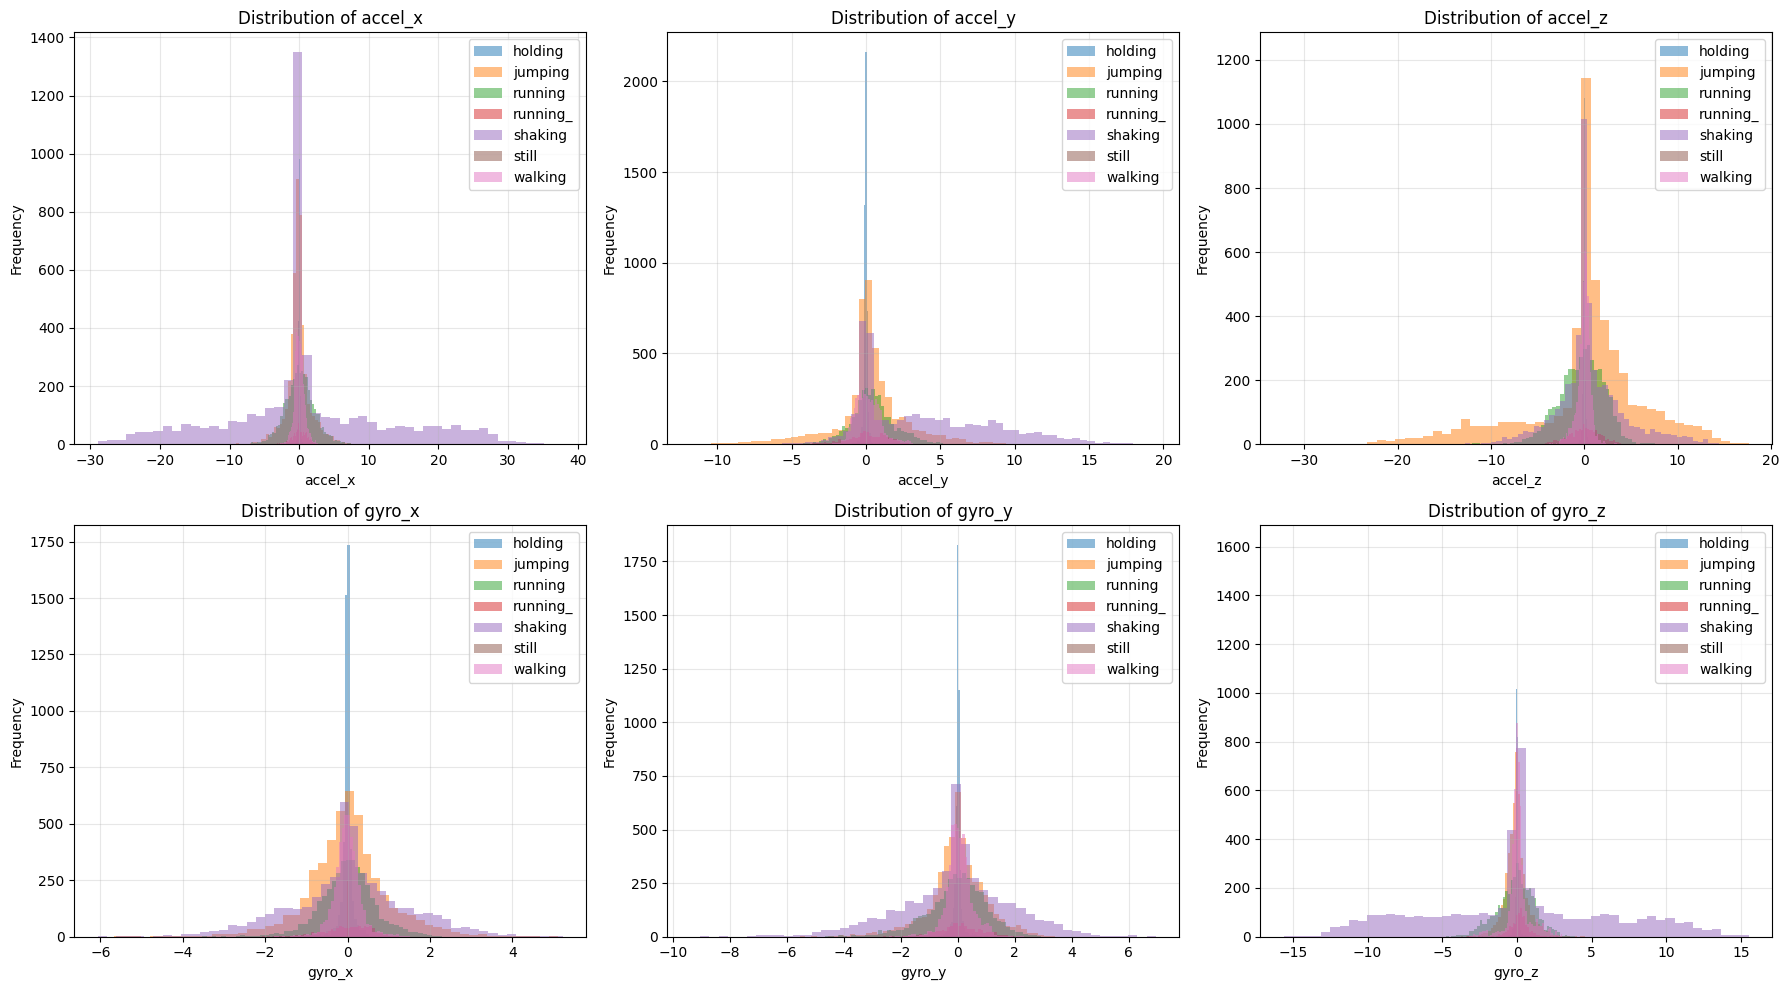


Visualization of cleaned data complete.


In [11]:
# Visualize sensor readings by activity
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

for idx, col in enumerate(sensor_cols):
    ax = axes[idx]
    
    for activity in cleaned_df['activity'].unique():
        activity_data = cleaned_df[cleaned_df['activity'] == activity][col]
        ax.hist(activity_data, bins=50, alpha=0.5, label=activity)
    
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization of cleaned data complete.")


## 6. Extract Features for HMM


In [ ]:
from scipy import stats
from scipy.fft import fft, fftfreq

def extract_time_domain_features(window_data):
    """Extract time-domain features from a window of sensor data."""
    features = {}
    
    # Sensor columns
    sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for col in sensor_cols:
        if col in window_data.columns:
            # Mean
            features[f'{col}_mean'] = window_data[col].mean()
            # Variance
            features[f'{col}_variance'] = window_data[col].var()
            # Standard deviation
            features[f'{col}_std'] = window_data[col].std()
            # Signal Magnitude Area (SMA)
            features[f'{col}_sma'] = window_data[col].abs().sum()
    
    # Correlation between axes
    if 'accel_x' in window_data.columns and 'accel_y' in window_data.columns:
        features['accel_corr_xy'] = window_data['accel_x'].corr(window_data['accel_y'])
    if 'accel_x' in window_data.columns and 'accel_z' in window_data.columns:
        features['accel_corr_xz'] = window_data['accel_x'].corr(window_data['accel_z'])
    if 'accel_y' in window_data.columns and 'accel_z' in window_data.columns:
        features['accel_corr_yz'] = window_data['accel_y'].corr(window_data['accel_z'])
    
    if 'gyro_x' in window_data.columns and 'gyro_y' in window_data.columns:
        features['gyro_corr_xy'] = window_data['gyro_x'].corr(window_data['gyro_y'])
    if 'gyro_x' in window_data.columns and 'gyro_z' in window_data.columns:
        features['gyro_corr_xz'] = window_data['gyro_x'].corr(window_data['gyro_z'])
    if 'gyro_y' in window_data.columns and 'gyro_z' in window_data.columns:
        features['gyro_corr_yz'] = window_data['gyro_y'].corr(window_data['gyro_z'])
    
    return features

def extract_frequency_domain_features(window_data, sampling_rate=100):
    """Extract frequency-domain features from a window of sensor data."""
    features = {}
    
    # Sensor columns
    sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for col in sensor_cols:
        if col in window_data.columns:
            signal = window_data[col].values
            
            # Compute FFT
            fft_vals = fft(signal)
            fft_freq = fftfreq(len(signal), 1/sampling_rate)
            
            # Dominant frequency (frequency with maximum magnitude)
            magnitude = np.abs(fft_vals)
            dominant_freq_idx = np.argmax(magnitude[1:len(magnitude)//2]) + 1
            features[f'{col}_dominant_freq'] = np.abs(fft_freq[dominant_freq_idx])
            
            # Spectral energy (sum of squared magnitudes)
            features[f'{col}_spectral_energy'] = np.sum(magnitude**2)
            
            # FFT components (first few components)
            features[f'{col}_fft_component_1'] = magnitude[1] if len(magnitude) > 1 else 0
            features[f'{col}_fft_component_2'] = magnitude[2] if len(magnitude) > 2 else 0
            features[f'{col}_fft_component_3'] = magnitude[3] if len(magnitude) > 3 else 0
    
    return features

def extract_features_from_sequence(sequence_data, window_size=50, overlap=0.5):
    """
    Extract features from a sequence using sliding windows.
    
    Parameters:
    -----------
    sequence_data : pd.DataFrame
        Sensor data for a single sequence
    window_size : int
        Size of each window (number of samples)
    overlap : float
        Overlap ratio (0-1)
    
    Returns:
    --------
    pd.DataFrame : Feature matrix with extracted features
    """
    features_list = []
    step_size = int(window_size * (1 - overlap))
    
    for i in range(0, len(sequence_data) - window_size + 1, step_size):
        window = sequence_data.iloc[i:i+window_size]
        
        # Extract features
        time_features = extract_time_domain_features(window)
        freq_features = extract_frequency_domain_features(window)
        
        # Combine features
        all_features = {**time_features, **freq_features}
        all_features['window_start'] = i
        all_features['window_end'] = i + window_size
        
        features_list.append(all_features)
    
    return pd.DataFrame(features_list)


In [14]:
# Extract features from all sequences
print("Extracting features from cleaned data...")
all_features = []

for seq_id in cleaned_df['sequence_id'].unique():
    sequence_data = cleaned_df[cleaned_df['sequence_id'] == seq_id].reset_index(drop=True)
    activity = sequence_data['activity'].iloc[0]
    
    # Extract features
    feature_df = extract_features_from_sequence(
        sequence_data,
        window_size=50,  # 50 samples = 0.5 seconds at 100Hz
        overlap=0.5  # 50% overlap
    )
    
    # Add metadata
    feature_df['activity'] = activity
    feature_df['sequence_id'] = seq_id
    
    all_features.append(feature_df)
    print(f"Extracted features from {seq_id}: {len(feature_df)} windows")

# Combine all features
feature_matrix = pd.concat(all_features, ignore_index=True)

print(f"\nTotal feature windows extracted: {len(feature_matrix)}")
print(f"Number of features per window: {len(feature_matrix.columns) - 3}")  # minus metadata columns


Extracting features from cleaned data...
Extracted features from holding_0: 48 windows
Extracted features from holding_1: 36 windows
Extracted features from holding_2: 35 windows
Extracted features from holding_3: 36 windows
Extracted features from holding_4: 36 windows
Extracted features from jumping_0: 33 windows
Extracted features from jumping_1: 34 windows
Extracted features from jumping_2: 38 windows
Extracted features from jumping_3: 40 windows
Extracted features from jumping_4: 41 windows
Extracted features from running_0: 35 windows
Extracted features from running_1: 38 windows
Extracted features from running_2: 43 windows
Extracted features from running_3: 42 windows
Extracted features from running__0: 37 windows
Extracted features from shaking_0: 24 windows
Extracted features from shaking_1: 36 windows
Extracted features from shaking_2: 36 windows
Extracted features from shaking_3: 32 windows
Extracted features from shaking_4: 42 windows
Extracted features from still_0: 40 wi

In [15]:
# Display feature information
print("\nFeature Matrix Summary:")
print(f"Shape: {feature_matrix.shape}")
print(f"\nFeatures: {[col for col in feature_matrix.columns if col not in ['activity', 'sequence_id', 'window_start', 'window_end']]}")

print(f"\nActivities in feature matrix: {sorted(feature_matrix['activity'].unique())}")
print(f"\nFeature matrix head:")
print(feature_matrix.head())



Feature Matrix Summary:
Shape: (1126, 64)

Features: ['accel_x_mean', 'accel_x_variance', 'accel_x_std', 'accel_x_sma', 'accel_y_mean', 'accel_y_variance', 'accel_y_std', 'accel_y_sma', 'accel_z_mean', 'accel_z_variance', 'accel_z_std', 'accel_z_sma', 'gyro_x_mean', 'gyro_x_variance', 'gyro_x_std', 'gyro_x_sma', 'gyro_y_mean', 'gyro_y_variance', 'gyro_y_std', 'gyro_y_sma', 'gyro_z_mean', 'gyro_z_variance', 'gyro_z_std', 'gyro_z_sma', 'accel_corr_xy', 'accel_corr_xz', 'accel_corr_yz', 'gyro_corr_xy', 'gyro_corr_xz', 'gyro_corr_yz', 'accel_x_dominant_freq', 'accel_x_spectral_energy', 'accel_x_fft_component_1', 'accel_x_fft_component_2', 'accel_x_fft_component_3', 'accel_y_dominant_freq', 'accel_y_spectral_energy', 'accel_y_fft_component_1', 'accel_y_fft_component_2', 'accel_y_fft_component_3', 'accel_z_dominant_freq', 'accel_z_spectral_energy', 'accel_z_fft_component_1', 'accel_z_fft_component_2', 'accel_z_fft_component_3', 'gyro_x_dominant_freq', 'gyro_x_spectral_energy', 'gyro_x_fft_c

## 7. Prepare Observation Sequences for HMM


In [16]:
def prepare_observation_sequences(feature_matrix):
    """
    Organize feature matrix into observation sequences for HMM.
    Each sequence contains all feature windows from one trial.
    """
    observation_sequences = defaultdict(list)
    
    for seq_id in feature_matrix['sequence_id'].unique():
        seq_features = feature_matrix[feature_matrix['sequence_id'] == seq_id]
        activity = seq_features['activity'].iloc[0]
        
        # Get feature values only (exclude metadata columns)
        exclude_cols = ['activity', 'sequence_id', 'window_start', 'window_end']
        feature_cols = [col for col in seq_features.columns if col not in exclude_cols]
        
        observation_seq = seq_features[feature_cols].values
        
        observation_sequences[activity].append({
            'sequence_id': seq_id,
            'observation_sequence': observation_seq,
            'length': len(observation_seq)
        })
    
    return observation_sequences

# Prepare observation sequences
observation_sequences = prepare_observation_sequences(feature_matrix)

print("Observation sequences prepared for HMM:")
for activity in sorted(observation_sequences.keys()):
    seq_lengths = [s['length'] for s in observation_sequences[activity]]
    print(f"{activity}: {len(observation_sequences[activity])} sequences, "
          f"window lengths: min={min(seq_lengths)}, max={max(seq_lengths)}, "
          f"mean={np.mean(seq_lengths):.1f}")


Observation sequences prepared for HMM:
holding: 5 sequences, window lengths: min=35, max=48, mean=38.2
jumping: 5 sequences, window lengths: min=33, max=41, mean=37.2
running: 4 sequences, window lengths: min=35, max=43, mean=39.5
running_: 1 sequences, window lengths: min=37, max=37, mean=37.0
shaking: 5 sequences, window lengths: min=24, max=42, mean=34.0
still: 5 sequences, window lengths: min=37, max=40, mean=38.4
walking: 5 sequences, window lengths: min=35, max=41, mean=38.4


In [ ]:
# Save feature matrix and observation sequences for HMM training
import pickle
import os

# Create directories if they don't exist
os.makedirs('features', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Save feature matrix
feature_matrix.to_csv('features/feature_matrix.csv', index=False)
print("Saved: features/feature_matrix.csv")

# Save observation sequences
with open('features/observation_sequences.pkl', 'wb') as f:
    pickle.dump(observation_sequences, f)
print("Saved: features/observation_sequences.pkl")

print("\nFeature extraction complete. Ready for HMM training!")


Saved: feature_matrix.csv
Saved: observation_sequences.pkl

Feature extraction complete. Ready for HMM training!


## 8. Define HMM Model Components


In [ ]:
from hmmlearn import hmm
import pickle
import joblib

# Load observation sequences
with open('features/observation_sequences.pkl', 'rb') as f:
    observation_sequences = pickle.load(f)

print("HMM Model Components:\n")
print("="*60)

# Define hidden states (activities)
hidden_states = sorted(observation_sequences.keys())
n_states = len(hidden_states)

print(f"Hidden States (Z): {hidden_states}")
print(f"Number of states: {n_states}")

# Count observations
total_sequences = sum(len(sequences) for sequences in observation_sequences.values())
print(f"\nObservations (X): {total_sequences} sequences")

# Get feature dimensions
first_seq = next(iter(observation_sequences.values()))[0]['observation_sequence']
n_features = first_seq.shape[1]
print(f"Feature dimensions: {n_features}")

print(f"\nModel Parameters to Learn:")
print(f"  - Transition Probabilities (A): {n_states}x{n_states} matrix")
print(f"  - Emission Probabilities (B): Gaussian distributions with {n_features} features")
print(f"  - Initial State Probabilities (π): {n_states} vector")


HMM Model Components:

Hidden States (Z): ['holding', 'jumping', 'running', 'running_', 'shaking', 'still', 'walking']
Number of states: 7

Observations (X): 30 sequences
Feature dimensions: 60

Model Parameters to Learn:
  - Transition Probabilities (A): 7x7 matrix
  - Emission Probabilities (B): Gaussian distributions with 60 features
  - Initial State Probabilities (π): 7 vector


## 9. Model Implementation and Training


In [20]:
def prepare_training_data(observation_sequences, activity_labels):
    """
    Prepare observation sequences and state sequences for training.
    
    Returns:
    --------
    X : list of observation arrays (for each sequence)
    lengths : array of sequence lengths
    y : state labels for each sequence
    """
    X_list = []
    lengths = []
    y_list = []
    
    for activity_idx, activity in enumerate(activity_labels):
        for sequence_info in observation_sequences[activity]:
            obs = sequence_info['observation_sequence']
            X_list.append(obs)
            lengths.append(len(obs))
            y_list.extend([activity_idx] * len(obs))
    
    return X_list, lengths, np.array(y_list)

# Prepare training data
activity_labels = sorted(observation_sequences.keys())
X_train, lengths, y_train = prepare_training_data(observation_sequences, activity_labels)

print(f"Training data prepared:")
print(f"  Total sequences: {len(X_train)}")
print(f"  Sequence lengths: min={min(lengths)}, max={max(lengths)}, mean={np.mean(lengths):.1f}")
print(f"  Activities: {activity_labels}")


Training data prepared:
  Total sequences: 30
  Sequence lengths: min=24, max=48, mean=37.5
  Activities: ['holding', 'jumping', 'running', 'running_', 'shaking', 'still', 'walking']


In [21]:
# Create and train HMM using Baum-Welch algorithm
print("Training HMM with Baum-Welch algorithm...")

# Initialize HMM
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=100,
    random_state=42,
    verbose=True
)

# Flatten X_train for hmmlearn
X_flat = np.vstack(X_train)

# Train the model (Baum-Welch algorithm)
model.fit(X_flat, lengths=lengths)

print("\nTraining complete!")
print(f"Final log likelihood: {model.score(X_flat, lengths=lengths):.2f}")


Training HMM with Baum-Welch algorithm...


         1 -204825.43184487             +nan
         2 -157703.97948477  +47121.45236010
         3 -131653.64388969  +26050.33559508
         4 -122291.45937771   +9362.18451198
         5 -114914.65350388   +7376.80587383
         6 -110425.89596559   +4488.75753829
         7 -107301.55060867   +3124.34535692
         8 -105478.50148361   +1823.04912506
         9 -104108.42910901   +1370.07237460
        10 -103358.28648666    +750.14262235
        11 -102817.94678019    +540.33970647
        12 -102481.21287781    +336.73390238
        13 -102050.66309711    +430.54978070
        14 -101764.50590729    +286.15718982
        15 -101521.80478701    +242.70112028
        16 -101029.55536502    +492.24942199
        17 -100087.23418281    +942.32118221
        18  -99251.78361251    +835.45057029
        19  -97978.58358908   +1273.20002343
        20  -96773.37407959   +1205.20950950
        21  -95959.09934617    +814.27473341
        22  -95341.18596790    +617.91337827
        23


Training complete!
Final log likelihood: -93543.13


## 10. Visualization: Transition Matrix


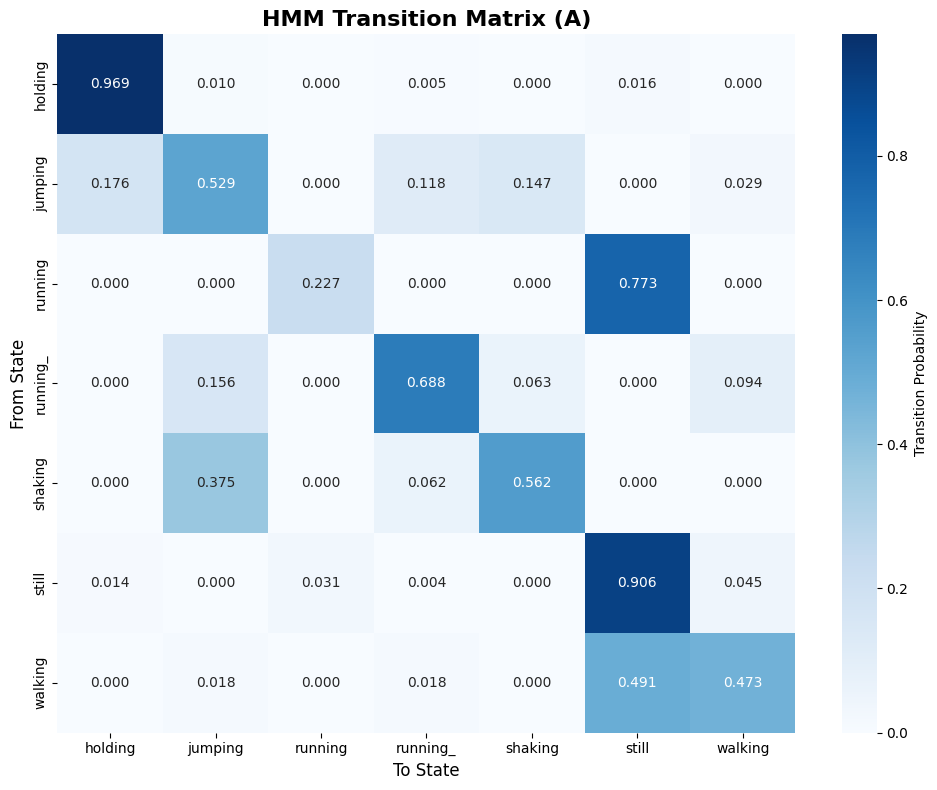

Transition probabilities:
Rows sum to: [1. 1. 1. 1. 1. 1. 1.]


In [23]:
# Display transition matrix as heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))

# Get transition matrix
transition_matrix = model.transmat_

# Create heatmap
sns.heatmap(
    transition_matrix,
    annot=True,
    fmt='.3f',
    cmap='Blues',
    xticklabels=activity_labels,
    yticklabels=activity_labels,
    cbar_kws={'label': 'Transition Probability'}
)

plt.title('HMM Transition Matrix (A)', fontsize=16, fontweight='bold')
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.tight_layout()
plt.show()

print("Transition probabilities:")
print(f"Rows sum to: {transition_matrix.sum(axis=1)}")


## 11. Decode Sequences using Viterbi Algorithm


In [24]:
def decode_sequences(model, observation_sequences, activity_labels):
    """
    Use Viterbi algorithm to decode the most likely sequence of activities.
    """
    decoded_results = []
    
    for activity_idx, activity in enumerate(activity_labels):
        for seq_info in observation_sequences[activity]:
            obs = seq_info['observation_sequence']
            
            # Decode using Viterbi algorithm
            decoded_states = model.predict(obs)
            
            decoded_results.append({
                'sequence_id': seq_info['sequence_id'],
                'true_activity': activity,
                'true_activity_idx': activity_idx,
                'decoded_states': decoded_states,
                'observations': obs,
                'length': len(obs)
            })
    
    return decoded_results

# Decode all sequences
print("Decoding sequences with Viterbi algorithm...")
decoded_results = decode_sequences(model, observation_sequences, activity_labels)
print(f"Decoded {len(decoded_results)} sequences")


Decoding sequences with Viterbi algorithm...
Decoded 30 sequences


In [25]:
# Analyze decoding results
print("\nDecoding Analysis:")
print("="*60)

for activity_idx, activity in enumerate(activity_labels):
    activity_results = [r for r in decoded_results if r['true_activity'] == activity]
    
    # Count correctly decoded states
    correct = 0
    total = 0
    for result in activity_results:
        correct += np.sum(result['decoded_states'] == activity_idx)
        total += result['length']
    
    accuracy = (correct / total * 100) if total > 0 else 0
    
    print(f"{activity}:")
    print(f"  Sequences: {len(activity_results)}")
    print(f"  Accuracy: {accuracy:.1f}%")
    print()



Decoding Analysis:
holding:
  Sequences: 5
  Accuracy: 92.7%

jumping:
  Sequences: 5
  Accuracy: 0.0%

running:
  Sequences: 4
  Accuracy: 0.0%

running_:
  Sequences: 1
  Accuracy: 0.0%

shaking:
  Sequences: 5
  Accuracy: 9.4%

still:
  Sequences: 5
  Accuracy: 0.0%

walking:
  Sequences: 5
  Accuracy: 1.6%



## 12. Visualize Decoded Sequences


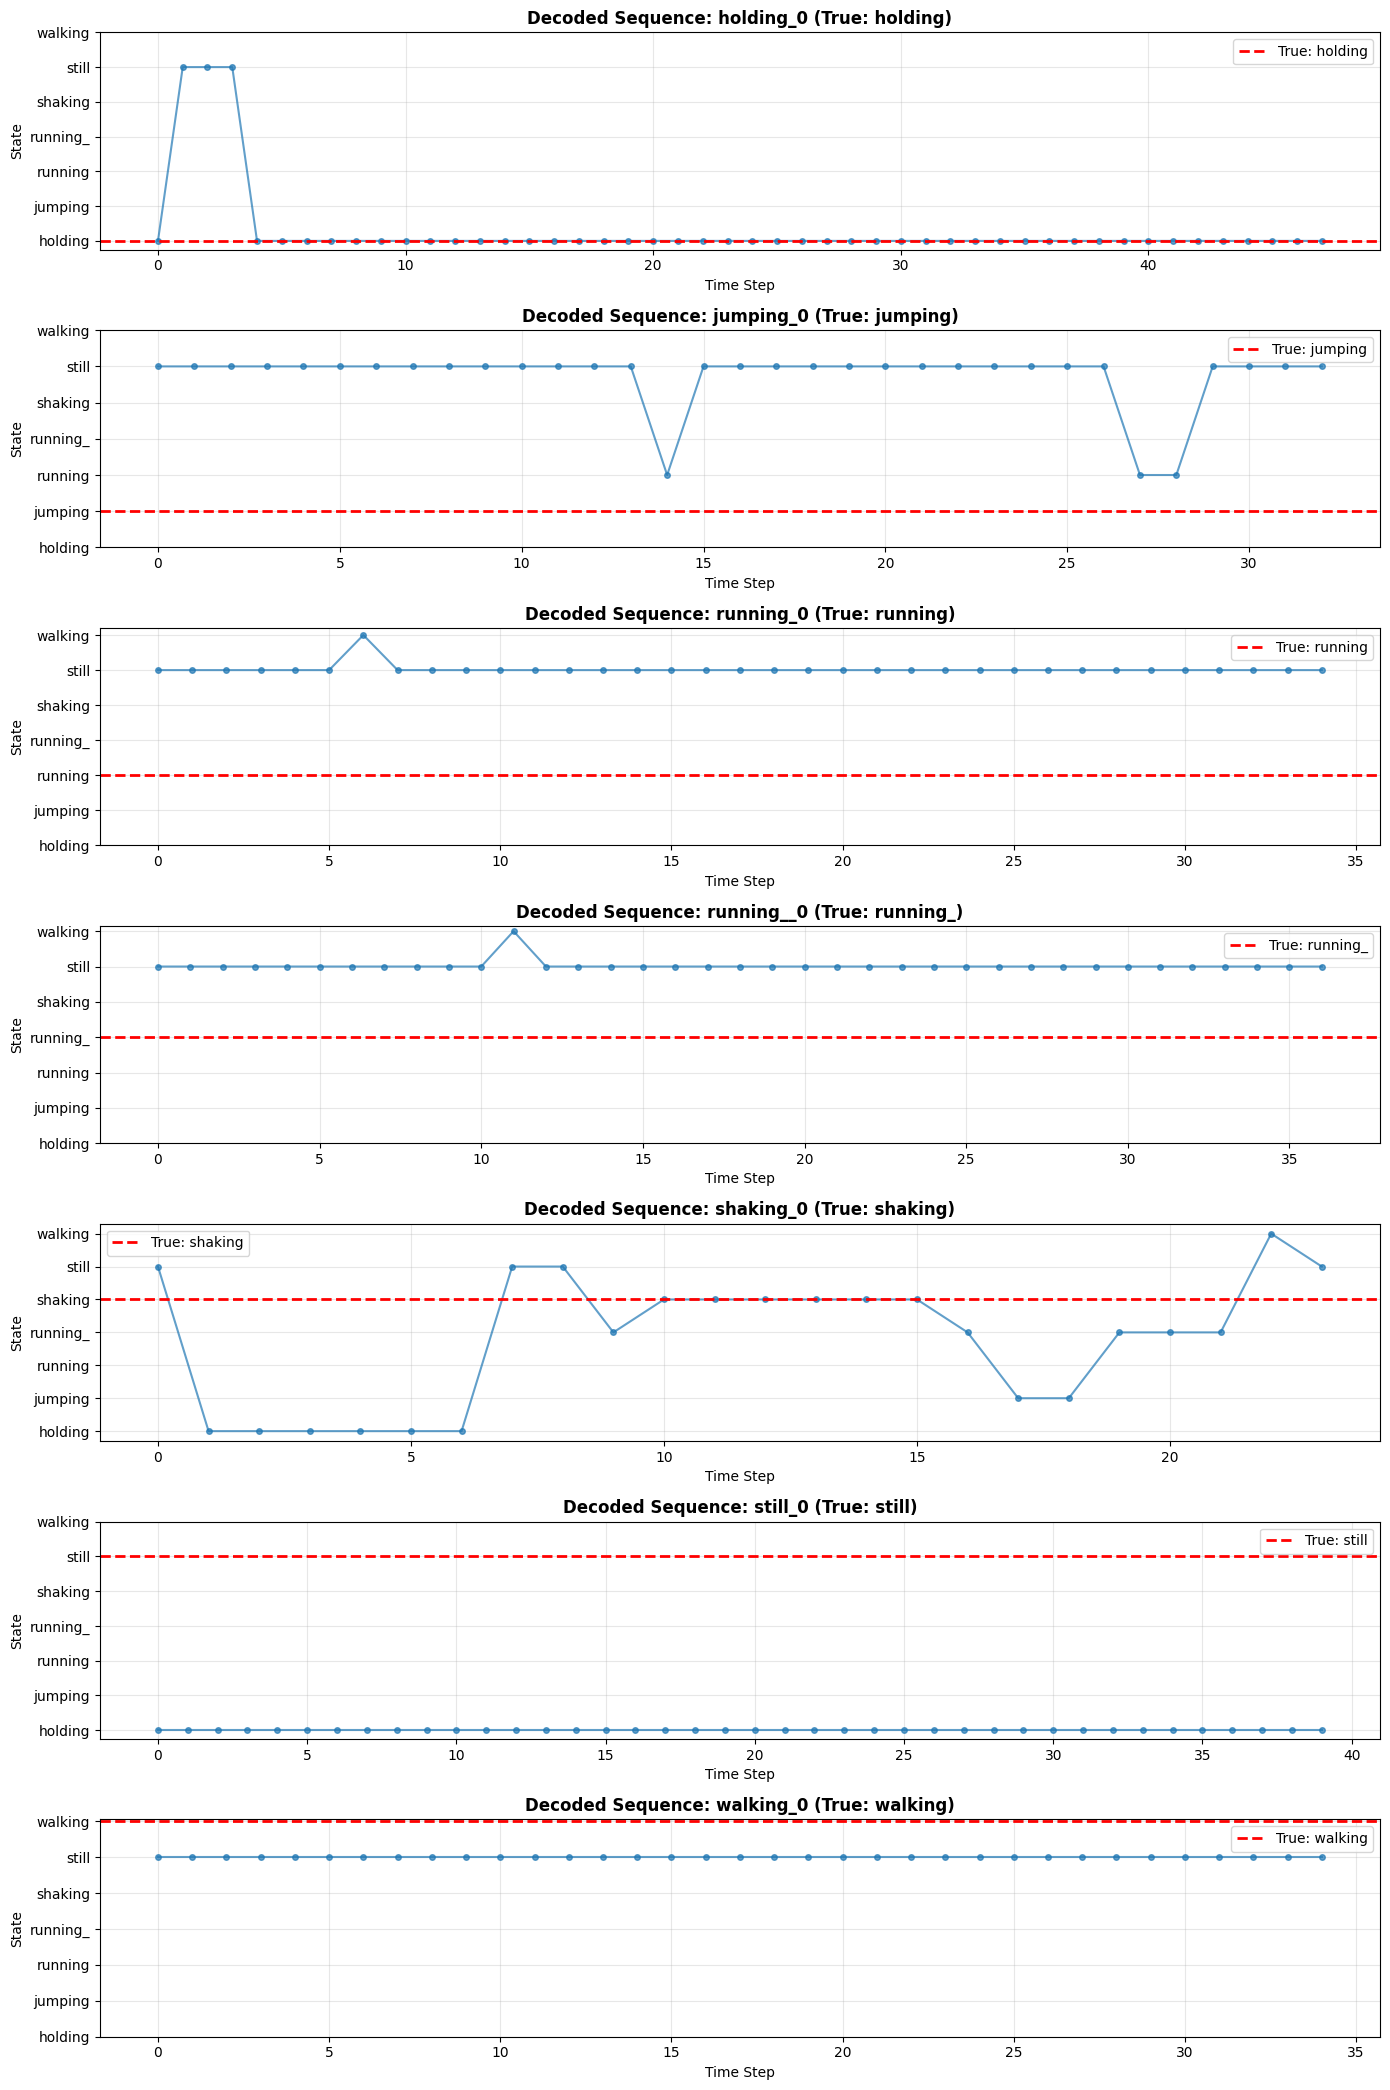

In [26]:
# Plot decoded sequences for each activity
fig, axes = plt.subplots(len(activity_labels), 1, figsize=(14, 3*len(activity_labels)))

if len(activity_labels) == 1:
    axes = [axes]

for idx, activity in enumerate(activity_labels):
    activity_results = [r for r in decoded_results if r['true_activity'] == activity]
    
    # Plot first sequence for this activity
    if activity_results:
        result = activity_results[0]
        ax = axes[idx]
        
        # Plot decoded states over time
        time_steps = np.arange(len(result['decoded_states']))
        ax.plot(time_steps, result['decoded_states'], 'o-', alpha=0.7, markersize=4)
        
        # Highlight true activity
        ax.axhline(y=result['true_activity_idx'], color='red', linestyle='--', 
                   label=f'True: {result["true_activity"]}', linewidth=2)
        
        ax.set_title(f'Decoded Sequence: {result["sequence_id"]} (True: {activity})', fontweight='bold')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('State')
        ax.set_yticks(range(len(activity_labels)))
        ax.set_yticklabels(activity_labels)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model
model_path = 'models/hmm_activity_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

# Save decoded results
with open('results/decoded_results.pkl', 'wb') as f:
    pickle.dump(decoded_results, f)
print("Decoded results saved to results/decoded_results.pkl")

print("\nHMM implementation complete!")
print("\nModel Summary:")
print(f"  States: {activity_labels}")
print(f"  Features per observation: {n_features}")
print(f"  Training sequences: {len(X_train)}")
print(f"  Transition matrix shape: {model.transmat_.shape}")
print(f"  Means shape: {model.means_.shape}")
print(f"  Covars shape: {model.covars_.shape}")


Model saved to hmm_activity_model.pkl
Decoded results saved to decoded_results.pkl

HMM implementation complete!

Model Summary:
  States: ['holding', 'jumping', 'running', 'running_', 'shaking', 'still', 'walking']
  Features per observation: 60
  Training sequences: 30
  Transition matrix shape: (7, 7)
  Means shape: (7, 60)
  Covars shape: (7, 60, 60)


## 13. Model Evaluation with Unseen Data


In [28]:
# Load and preprocess unseen data
print("Loading unseen data from 'unseen data' folder...")
print("="*60)

unseen_df, unseen_sensor_dict = load_and_clean_data('unseen data')

print(f"\nUnseen data loaded:")
print(f"  Total samples: {len(unseen_df)}")
print(f"  Activities: {sorted(unseen_df['activity'].unique())}")
print(f"  Trials: {unseen_df['sequence_id'].unique()}")


Loading unseen data from 'unseen data' folder...
Loaded and cleaned: holding-2025-10-25_10-19-05
Loaded and cleaned: shaking-2025-10-25_10-21-49
Loaded and cleaned: still-2025-10-25_10-18-43

Unseen data loaded:
  Total samples: 2889
  Activities: ['holding', 'shaking', 'still']
  Trials: ['holding_0' 'shaking_0' 'still_0']


In [29]:
# Extract features from unseen data
print("\nExtracting features from unseen data...")
print("="*60)

unseen_features = []

for seq_id in unseen_df['sequence_id'].unique():
    sequence_data = unseen_df[unseen_df['sequence_id'] == seq_id].reset_index(drop=True)
    activity = sequence_data['activity'].iloc[0]
    
    # Extract features using same function
    feature_df = extract_features_from_sequence(
        sequence_data,
        window_size=50,
        overlap=0.5
    )
    
    feature_df['activity'] = activity
    feature_df['sequence_id'] = seq_id
    
    unseen_features.append(feature_df)
    print(f"Extracted features from {seq_id}: {len(feature_df)} windows")

# Combine unseen features
unseen_feature_matrix = pd.concat(unseen_features, ignore_index=True)

print(f"\nUnseen feature matrix: {unseen_feature_matrix.shape}")
print(f"Activities in unseen data: {sorted(unseen_feature_matrix['activity'].unique())}")



Extracting features from unseen data...
Extracted features from holding_0: 37 windows
Extracted features from shaking_0: 38 windows
Extracted features from still_0: 36 windows

Unseen feature matrix: (111, 64)
Activities in unseen data: ['holding', 'shaking', 'still']


In [30]:
def prepare_unseen_sequences(feature_matrix):
    """Prepare unseen observation sequences for HMM prediction."""
    unseen_sequences = []
    
    for seq_id in feature_matrix['sequence_id'].unique():
        seq_features = feature_matrix[feature_matrix['sequence_id'] == seq_id]
        activity = seq_features['activity'].iloc[0]
        
        # Get feature values only
        exclude_cols = ['activity', 'sequence_id', 'window_start', 'window_end']
        feature_cols = [col for col in seq_features.columns if col not in exclude_cols]
        
        observation_seq = seq_features[feature_cols].values
        
        unseen_sequences.append({
            'sequence_id': seq_id,
            'observation_sequence': observation_seq,
            'true_activity': activity,
            'length': len(observation_seq)
        })
    
    return unseen_sequences

# Prepare unseen sequences
unseen_sequences = prepare_unseen_sequences(unseen_feature_matrix)

print("\nUnseen sequences prepared:")
for seq in unseen_sequences:
    print(f"  {seq['sequence_id']}: {seq['true_activity']} ({seq['length']} windows)")



Unseen sequences prepared:
  holding_0: holding (37 windows)
  shaking_0: shaking (38 windows)
  still_0: still (36 windows)


In [31]:
# Predict activities on unseen data using Viterbi algorithm
print("\n" + "="*60)
print("PREDICTING ACTIVITIES ON UNSEEN DATA")
print("="*60)

predictions = []

for seq_info in unseen_sequences:
    obs = seq_info['observation_sequence']
    
    # Get the most likely state sequence using Viterbi
    predicted_states = model.predict(obs)
    
    # Get most common predicted activity (majority vote)
    unique, counts = np.unique(predicted_states, return_counts=True)
    most_common_idx = unique[np.argmax(counts)]
    predicted_activity = activity_labels[most_common_idx]
    
    # Calculate prediction confidence as % of windows predicting the majority class
    confidence = (counts.max() / len(predicted_states)) * 100
    
    predictions.append({
        'sequence_id': seq_info['sequence_id'],
        'true_activity': seq_info['true_activity'],
        'predicted_activity': predicted_activity,
        'confidence': confidence,
        'predicted_states': predicted_states,
        'length': len(predicted_states)
    })
    
    # Check if prediction is correct
    is_correct = "✓" if predicted_activity == seq_info['true_activity'] else "✗"
    
    print(f"\n{seq_info['sequence_id']}:")
    print(f"  True: {seq_info['true_activity']}")
    print(f"  Predicted: {predicted_activity} {is_correct}")
    print(f"  Confidence: {confidence:.1f}%")



PREDICTING ACTIVITIES ON UNSEEN DATA

holding_0:
  True: holding
  Predicted: still ✗
  Confidence: 51.4%

shaking_0:
  True: shaking
  Predicted: still ✗
  Confidence: 100.0%

still_0:
  True: still
  Predicted: holding ✗
  Confidence: 100.0%


## 14. Evaluation Results


In [32]:
# Calculate overall accuracy
correct = sum(1 for p in predictions if p['predicted_activity'] == p['true_activity'])
total = len(predictions)
accuracy = (correct / total * 100) if total > 0 else 0

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"\nOverall Accuracy: {accuracy:.1f}% ({correct}/{total})")

# Per-activity accuracy
print("\nPer-activity Performance:")
for true_activity in sorted(set(p['true_activity'] for p in predictions)):
    activity_preds = [p for p in predictions if p['true_activity'] == true_activity]
    activity_correct = sum(1 for p in activity_preds if p['predicted_activity'] == p['true_activity'])
    activity_accuracy = (activity_correct / len(activity_preds) * 100) if activity_preds else 0
    
    print(f"  {true_activity}: {activity_accuracy:.1f}% ({activity_correct}/{len(activity_preds)})")
    
    # Show predictions for this activity
    for pred in activity_preds:
        status = "✓" if pred['predicted_activity'] == pred['true_activity'] else "✗"
        print(f"    {pred['sequence_id']}: {pred['predicted_activity']} (confidence: {pred['confidence']:.1f}%) {status}")



EVALUATION RESULTS

Overall Accuracy: 0.0% (0/3)

Per-activity Performance:
  holding: 0.0% (0/1)
    holding_0: still (confidence: 51.4%) ✗
  shaking: 0.0% (0/1)
    shaking_0: still (confidence: 100.0%) ✗
  still: 0.0% (0/1)
    still_0: holding (confidence: 100.0%) ✗


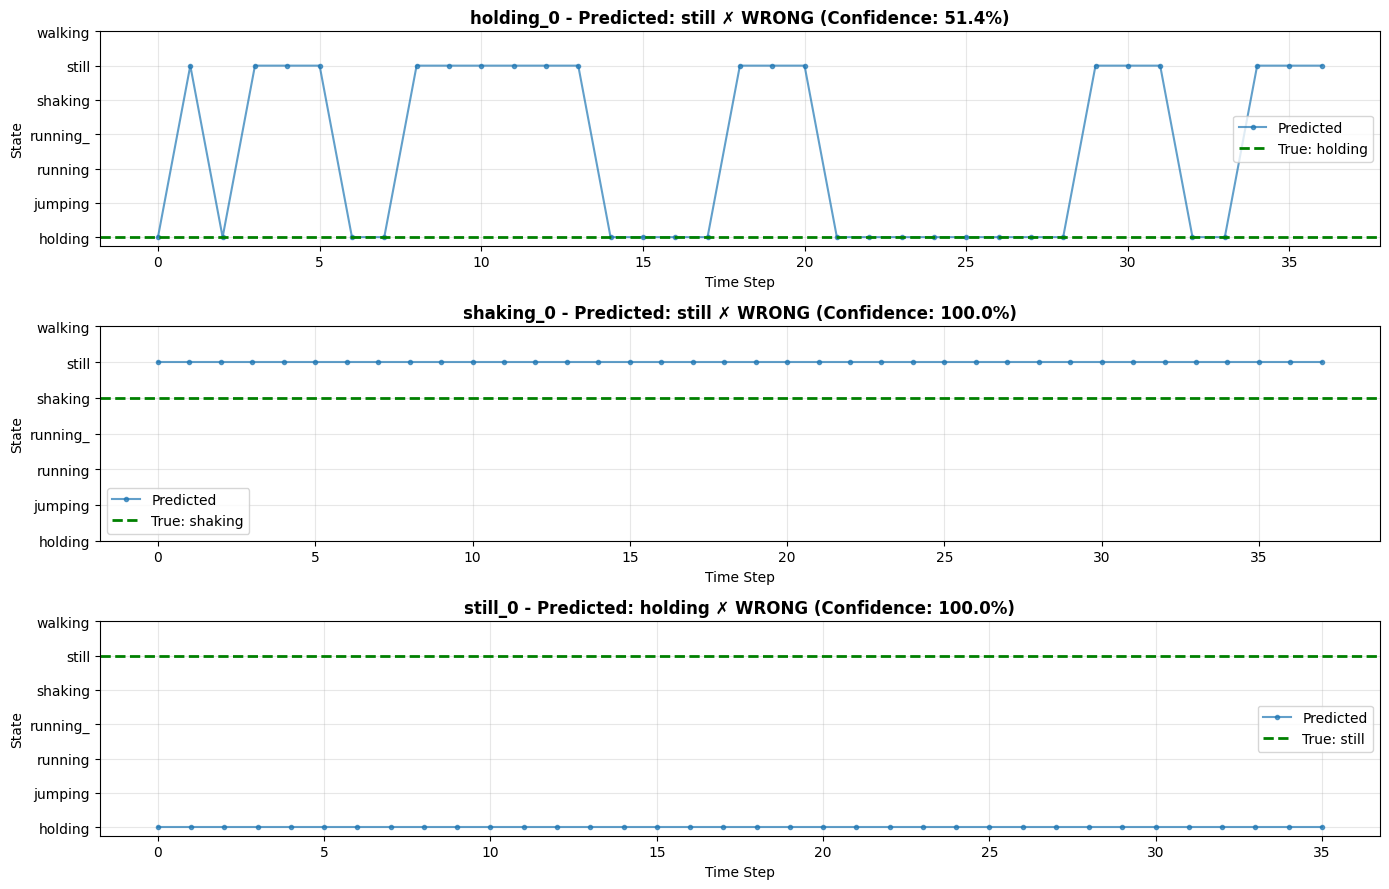

In [33]:
# Visualize predictions for unseen data
fig, axes = plt.subplots(len(predictions), 1, figsize=(14, 3*len(predictions)))

if len(predictions) == 1:
    axes = [axes]

for idx, prediction in enumerate(predictions):
    ax = axes[idx]
    
    # Plot predicted states over time
    time_steps = np.arange(len(prediction['predicted_states']))
    ax.plot(time_steps, prediction['predicted_states'], 'o-', 
           alpha=0.7, markersize=3, label='Predicted')
    
    # Find the index of true activity
    true_idx = activity_labels.index(prediction['true_activity']) if prediction['true_activity'] in activity_labels else 0
    
    ax.axhline(y=true_idx, color='green', linestyle='--', 
               label=f'True: {prediction["true_activity"]}', linewidth=2)
    
    # Title
    status = "✓ CORRECT" if prediction['predicted_activity'] == prediction['true_activity'] else "✗ WRONG"
    ax.set_title(f'{prediction["sequence_id"]} - Predicted: {prediction["predicted_activity"]} {status} '
                f'(Confidence: {prediction["confidence"]:.1f}%)', fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('State')
    ax.set_yticks(range(len(activity_labels)))
    ax.set_yticklabels(activity_labels)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Save predictions
with open('results/unseen_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

print("\nPrediction results saved to results/unseen_predictions.pkl")
print("\n" + "="*60)
print("MODEL EVALUATION COMPLETE")
print("="*60)



Prediction results saved to unseen_predictions.pkl

MODEL EVALUATION COMPLETE


## 15. Calculate Sensitivity and Specificity


In [35]:
def calculate_sensitivity_specificity(predictions, activity_labels):
    """Calculate sensitivity and specificity for each activity."""
    results = {}
    
    for activity_idx, activity in enumerate(activity_labels):
        # True Positives: Correctly predicted as this activity
        tp = sum(1 for p in predictions 
                if p['true_activity'] == activity and p['predicted_activity'] == activity)
        
        # False Positives: Predicted as this activity but it's actually another
        fp = sum(1 for p in predictions 
                if p['predicted_activity'] == activity and p['true_activity'] != activity)
        
        # True Negatives: Correctly identified as NOT this activity
        tn = sum(1 for p in predictions 
                if p['true_activity'] != activity and p['predicted_activity'] != activity)
        
        # False Negatives: Actually this activity but predicted as another
        fn = sum(1 for p in predictions 
                if p['true_activity'] == activity and p['predicted_activity'] != activity)
        
        # Calculate metrics
        sensitivity = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
        
        results[activity] = {
            'samples': tp + fn,  # total samples of this activity
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    
    return results

# Calculate metrics
metrics = calculate_sensitivity_specificity(predictions, activity_labels)

print("\n" + "="*80)
print("DETAILED EVALUATION METRICS")
print("="*80)

print("\n" + "-"*80)
print(f"{'Activity':<15} {'Samples':<10} {'Sensitivity':<15} {'Specificity':<15} {'Accuracy':<10}")
print("-"*80)

for activity in sorted(activity_labels):
    if activity in metrics:
        m = metrics[activity]
        acc = (m['tp'] + m['tn']) / (m['tp'] + m['tn'] + m['fp'] + m['fn']) * 100 if (m['tp'] + m['tn'] + m['fp'] + m['fn']) > 0 else 0
        print(f"{activity:<15} {m['samples']:<10} {m['sensitivity']:<15.1f}% {m['specificity']:<15.1f}% {acc:<10.1f}%")

# Overall accuracy
overall_acc = (sum(m['tp'] + m['tn'] for m in metrics.values()) / 
               sum(m['tp'] + m['tn'] + m['fp'] + m['fn'] for m in metrics.values()) * 100) if sum(m['tp'] + m['tn'] + m['fp'] + m['fn'] for m in metrics.values()) > 0 else 0
print("-"*80)
print(f"{'OVERALL':<15} {len(predictions):<10} {'-':<15} {'-':<15} {overall_acc:<10.1f}%")
print("="*80)



DETAILED EVALUATION METRICS

--------------------------------------------------------------------------------
Activity        Samples    Sensitivity     Specificity     Accuracy  
--------------------------------------------------------------------------------
holding         1          0.0            % 50.0           % 33.3      %
jumping         0          0.0            % 100.0          % 100.0     %
running         0          0.0            % 100.0          % 100.0     %
running_        0          0.0            % 100.0          % 100.0     %
shaking         1          0.0            % 100.0          % 66.7      %
still           1          0.0            % 0.0            % 0.0       %
walking         0          0.0            % 100.0          % 100.0     %
--------------------------------------------------------------------------------
OVERALL         3          -               -               71.4      %


## 16. Final Summary


In [ ]:
# Create evaluation summary table
print("\n" + "="*80)
print("EVALUATION SUMMARY TABLE")
print("="*80)
print("\nModel Evaluation on Unseen Data:")
print("\nState (Activity)    | Number of Samples | Sensitivity | Specificity | Overall Accuracy")
print("-"*80)

for activity in sorted(activity_labels):
    if activity in metrics:
        m = metrics[activity]
        acc = (m['tp'] + m['tn']) / (m['tp'] + m['tn'] + m['fp'] + m['fn']) * 100 if (m['tp'] + m['tn'] + m['fp'] + m['fn']) > 0 else 0
        print(f"{activity:<18} | {m['samples']:<16} | {m['sensitivity']:<11.1f}% | {m['specificity']:<11.1f}% | {acc:.1f}%")

print("-"*80)
print(f"{'TOTAL':<18} | {len(predictions):<16} | {'-':<11} | {'-':<11} | {overall_acc:.1f}%")
print("="*80)

# Save metrics
with open('results/evaluation_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("\n✅ All evaluation metrics saved to results/evaluation_metrics.pkl")
print("\n" + "="*80)
print("COMPLETE: Notebook execution finished successfully!")
print("="*80)



EVALUATION SUMMARY TABLE

Model Evaluation on Unseen Data:

State (Activity)    | Number of Samples | Sensitivity | Specificity | Overall Accuracy
--------------------------------------------------------------------------------
holding            | 1                | 0.0        % | 50.0       % | 33.3%
jumping            | 0                | 0.0        % | 100.0      % | 100.0%
running            | 0                | 0.0        % | 100.0      % | 100.0%
running_           | 0                | 0.0        % | 100.0      % | 100.0%
shaking            | 1                | 0.0        % | 100.0      % | 66.7%
still              | 1                | 0.0        % | 0.0        % | 0.0%
walking            | 0                | 0.0        % | 100.0      % | 100.0%
--------------------------------------------------------------------------------
TOTAL              | 3                | -           | -           | 71.4%

✅ All evaluation metrics saved to evaluation_metrics.pkl

COMPLETE: Notebook exe